Helpful links for processing graphs on pyspark:

https://docs.databricks.com/spark/latest/graph-analysis/graphframes/user-guide-python.html

https://graphframes.github.io/graphframes/docs/_site/user-guide.html

https://pysparktutorial.blogspot.com/2017/10/graphframes-pyspark.html

In [1]:
import findspark
findspark.init()
from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.sql.functions import col, size
import pyspark.sql.functions as fn

In [2]:
# Start spark in local mode using 54gb of memory
# local mode only runs on a single node, but it will utilize all cores (We have 48!)
conf = SparkConf().setAppName("test") \
    .setMaster("local[44]") \
    .set('spark.driver.memory','54g') \
    .set('spark.jars.packages', 'graphframes:graphframes:0.7.0-spark2.4-s_2.11')
#.setMaster("yarn") # this is used when we run on hadoop, ignore for now

sc = SparkContext(conf = conf)
sqlContext = SQLContext(sc)

print("Spark Version: ", sc.version)
print("defaultParallelism: ", sc.defaultParallelism)
print("Spark WebURLL ", sc.uiWebUrl) # you can view running jobs here, but I am only able to connect to it via VNC rn, maybe SSH tunneling will fix this? idk

Spark Version:  2.4.4
defaultParallelism:  44
Spark WebURLL  http://c251-110.wrangler.tacc.utexas.edu:4040


In [3]:
sc._conf.getAll() # See all the current Spark configuration settings

[('spark.driver.host', 'c251-110.wrangler.tacc.utexas.edu'),
 ('spark.driver.port', '37189'),
 ('spark.jars.packages', 'graphframes:graphframes:0.7.0-spark2.4-s_2.11'),
 ('spark.app.id', 'local-1573691165420'),
 ('spark.app.name', 'test'),
 ('spark.driver.memory', '54g'),
 ('spark.files',
  'file:///home/06271/cju256/.ivy2/jars/graphframes_graphframes-0.7.0-spark2.4-s_2.11.jar,file:///home/06271/cju256/.ivy2/jars/org.slf4j_slf4j-api-1.7.16.jar'),
 ('spark.executor.id', 'driver'),
 ('spark.local.dir', '/data/06271/cju256/temp'),
 ('spark.master', 'local[44]'),
 ('spark.submit.pyFiles',
  '/home/06271/cju256/.ivy2/jars/graphframes_graphframes-0.7.0-spark2.4-s_2.11.jar,/home/06271/cju256/.ivy2/jars/org.slf4j_slf4j-api-1.7.16.jar'),
 ('spark.rdd.compress', 'True'),
 ('spark.repl.local.jars',
  'file:///home/06271/cju256/.ivy2/jars/graphframes_graphframes-0.7.0-spark2.4-s_2.11.jar,file:///home/06271/cju256/.ivy2/jars/org.slf4j_slf4j-api-1.7.16.jar'),
 ('spark.serializer.objectStreamReset', 

In [4]:
from functools import reduce
from pyspark.sql.functions import col, lit, when
from graphframes import *

In [12]:
from pyspark.sql import functions as F

In [5]:
nodes_path = '/data/06271/cju256/nodes.json'
edges_path = '/data/06271/cju256/edges.json'

nodes = sqlContext.read.json(nodes_path)
edges = sqlContext.read.json(edges_path)

In [6]:
nodes.printSchema()

root
 |-- about: string (nullable = true)
 |-- cancelled: boolean (nullable = true)
 |-- date_created: string (nullable = true)
 |-- email: string (nullable = true)
 |-- external_id: string (nullable = true)
 |-- firstname: string (nullable = true)
 |-- friends: string (nullable = true)
 |-- id: long (nullable = true)
 |-- is_business: boolean (nullable = true)
 |-- lastname: string (nullable = true)
 |-- name: string (nullable = true)
 |-- num_friends: long (nullable = true)
 |-- phone: string (nullable = true)
 |-- picture: string (nullable = true)
 |-- username: string (nullable = true)



In [7]:
edges.printSchema()

root
 |-- _id: string (nullable = true)
 |-- comments_count: long (nullable = true)
 |-- created_time: string (nullable = true)
 |-- dst: long (nullable = true)
 |-- likes_count: long (nullable = true)
 |-- mentions_count: long (nullable = true)
 |-- message: string (nullable = true)
 |-- payment_id: long (nullable = true)
 |-- permalink: string (nullable = true)
 |-- src: long (nullable = true)
 |-- type: string (nullable = true)
 |-- unix_time: long (nullable = true)
 |-- updated_time: string (nullable = true)



In [8]:
from pyspark.sql.types import StringType, IntegerType, LongType, TimestampType

new_nodes = nodes.withColumn("id_string", col('id').cast(LongType())).drop('id').withColumnRenamed("id_string",'id')
new_edges = edges \
                .withColumn("src_string", col('src').cast(LongType())).drop('src').withColumnRenamed("src_string",'src') \
                .withColumn("dst_string", col('dst').cast(LongType())).drop('dst').withColumnRenamed("dst_string",'dst') \
                .withColumn("created_time_tmp", col('created_time').cast(TimestampType())).drop('created_time').withColumnRenamed('created_time_tmp', 'created_time') \
                .withColumn("updated_time_tmp", col('updated_time').cast(TimestampType())).drop('updated_time').withColumnRenamed('updated_time_tmp', 'updated_time') \
                .withColumn('epoch_time', col('unix_time').cast(TimestampType()))

In [9]:
new_edges.printSchema()

root
 |-- _id: string (nullable = true)
 |-- comments_count: long (nullable = true)
 |-- likes_count: long (nullable = true)
 |-- mentions_count: long (nullable = true)
 |-- message: string (nullable = true)
 |-- payment_id: long (nullable = true)
 |-- permalink: string (nullable = true)
 |-- type: string (nullable = true)
 |-- unix_time: long (nullable = true)
 |-- src: long (nullable = true)
 |-- dst: long (nullable = true)
 |-- created_time: timestamp (nullable = true)
 |-- updated_time: timestamp (nullable = true)
 |-- epoch_time: timestamp (nullable = true)



In [10]:
new_edges.select('src', 'dst', 'created_time', 'updated_time', 'unix_time', 'epoch_time').show()

+------+------+-------------------+-------------------+----------+-------------------+
|   src|   dst|       created_time|       updated_time| unix_time|         epoch_time|
+------+------+-------------------+-------------------+----------+-------------------+
| 59741| 33632|2012-05-01 19:28:48|2012-05-01 19:28:48|1335918528|2012-05-01 19:28:48|
|111497|110891|2012-05-04 15:09:46|2012-05-04 15:09:46|1336162186|2012-05-04 15:09:46|
| 34421| 22792|2012-05-04 18:38:24|2012-05-04 18:38:24|1336174704|2012-05-04 18:38:24|
| 85649|107484|2012-04-20 11:11:52|2012-04-20 11:11:52|1334938312|2012-04-20 11:11:52|
| 26924| 34907|2012-05-04 18:42:56|2012-05-04 18:42:56|1336174976|2012-05-04 18:42:56|
|115128|115131|2012-06-17 15:40:12|2012-06-17 15:40:12|1339965612|2012-06-17 15:40:12|
| 74104| 65588|2012-05-28 19:37:49|2012-05-28 19:37:49|1338251869|2012-05-28 19:37:49|
| 71313| 60063|2012-06-23 18:04:27|2012-06-23 18:04:27|1340492667|2012-06-23 18:04:27|
| 29674| 22222|2012-06-30 21:28:58|2012-06-

In [30]:
dates = ("2013",  "2017")

onlyFullYears = new_edges.select('*', F.date_format('epoch_time', "yyyy").alias('year')) \
        .where(col('year').between(*dates))

In [31]:
daysOfYear = onlyFullYears.select(F.date_format('epoch_time','MM-dd').alias('daysOfYear')).groupby('daysOfYear').count().persist()

In [32]:
daysOfYear.orderBy('daysOfYear').show(400)

+----------+-------+
|daysOfYear|  count|
+----------+-------+
|     01-01| 509856|
|     01-02| 486928|
|     01-03| 458690|
|     01-04| 430636|
|     01-05| 411070|
|     01-06| 447323|
|     01-07| 452784|
|     01-08| 469463|
|     01-09| 470959|
|     01-10| 443102|
|     01-11| 426515|
|     01-12| 425896|
|     01-13| 514327|
|     01-14| 517015|
|     01-15| 559671|
|     01-16| 539818|
|     01-17| 494153|
|     01-18| 475489|
|     01-19| 467393|
|     01-20| 535053|
|     01-21| 569139|
|     01-22| 585127|
|     01-23| 496347|
|     01-24| 496261|
|     01-25| 469781|
|     01-26| 476035|
|     01-27| 561218|
|     01-28| 591252|
|     01-29| 609767|
|     01-30| 574530|
|     01-31| 591206|
|     02-01| 603982|
|     02-02| 552741|
|     02-03| 623962|
|     02-04| 626664|
|     02-05| 759096|
|     02-06| 601935|
|     02-07| 600526|
|     02-08| 529615|
|     02-09| 508184|
|     02-10| 589299|
|     02-11| 612723|
|     02-12| 618914|
|     02-13| 572989|
|     02-14| 

In [33]:
import pandas as pd

days_df = daysOfYear.orderBy('daysOfYear').toPandas()
days_df.head()

,daysOfYear,count
0,01-01,509856
1,01-02,486928
2,01-03,458690
3,01-04,430636
4,01-05,411070


In [50]:
pd.set_option('display.max_rows', 500)
days_df.head(365)

,daysOfYear,count
0,01-01,509856
1,01-02,486928
2,01-03,458690
3,01-04,430636
4,01-05,411070
5,01-06,447323
6,01-07,452784
7,01-08,469463
8,01-09,470959
9,01-10,443102


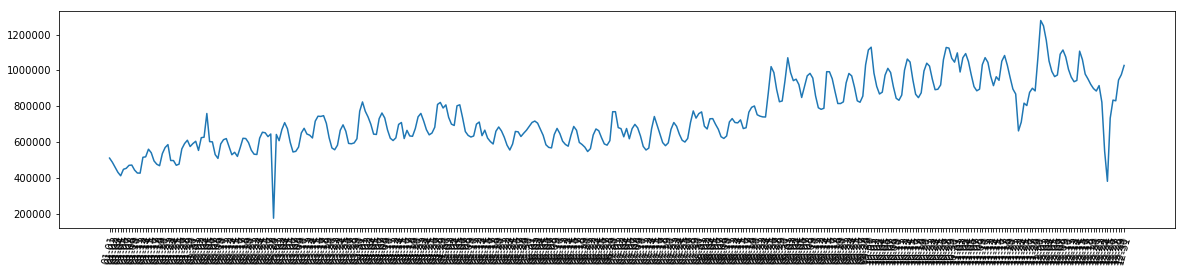

In [36]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,4))

plt.xticks(rotation=75)
plt.plot(days_df['daysOfYear'], days_df['count'])

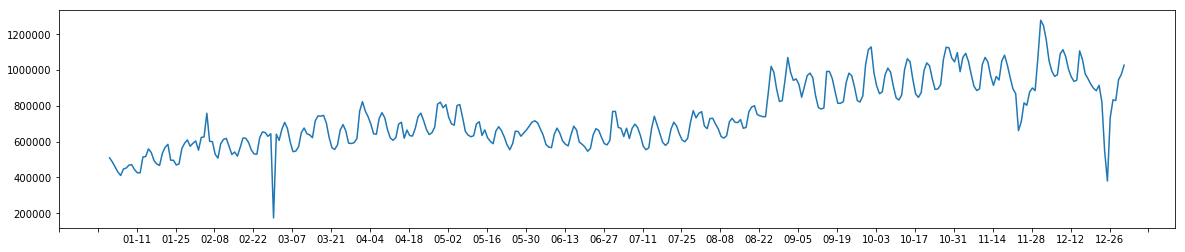

In [45]:
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(days_df['daysOfYear'], days_df['count'])


start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 14))
#ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
plt.show()

In [ ]:
from pyspark.sql import functions as F

year_month = new_edges.select(F.date_format('epoch_time','yyyy-MM').alias('month')).groupby('month').count().persist()

In [51]:
new_edges.select('*', F.date_format('epoch_time', "yyyy-MM").alias('year_month')) \
            .filter(col('year_month') == lit('2012-03')).show()

+--------------------+--------------+-----------+--------------+--------------------+----------+--------------------+-------+----------+------+------+-------------------+-------------------+-------------------+----------+
|                 _id|comments_count|likes_count|mentions_count|             message|payment_id|           permalink|   type| unix_time|   src|   dst|       created_time|       updated_time|         epoch_time|year_month|
+--------------------+--------------+-----------+--------------+--------------------+----------+--------------------+-------+----------+------+------+-------------------+-------------------+-------------------+----------+
|5b733352eabb718e7...|             2|          0|             0|For a wheat beer....|    423331|/story/4f73bb8633...|payment|1332984710|    11|    42|2012-03-28 20:31:50|2012-03-28 23:59:58|2012-03-28 20:31:50|   2012-03|
|5b7335e6eabb718e7...|             2|          0|             0|Let me get half s...|    426304|/story/4f75f9a13

In [52]:
year_month.orderBy('month').show(200)

+-------+--------+
|  month|   count|
+-------+--------+
|2012-03|      15|
|2012-04|    3280|
|2012-05|    4433|
|2012-06|    4756|
|2012-07|    5571|
|2012-08|    7338|
|2012-09|    9769|
|2012-10|   11965|
|2012-11|   13677|
|2012-12|   16453|
|2013-01|   21337|
|2013-02|   25457|
|2013-03|   33211|
|2013-04|   40643|
|2013-05|   48467|
|2013-06|   50822|
|2013-07|   64736|
|2013-08|   88611|
|2013-09|  120736|
|2013-10|  147528|
|2013-11|  173434|
|2013-12|  192545|
|2014-01|  256247|
|2014-02|  301696|
|2014-03|  410951|
|2014-04|  464851|
|2014-05|  530547|
|2014-06|  524249|
|2014-07|  589398|
|2014-08|  733758|
|2014-09|  901403|
|2014-10| 1049696|
|2014-11| 1120404|
|2014-12| 1156727|
|2015-01| 1412554|
|2015-02| 1568348|
|2015-03| 1962782|
|2015-04| 2128499|
|2015-05| 2312411|
|2015-06| 2040899|
|2015-07| 2245847|
|2015-08| 2642943|
|2015-09| 3161513|
|2015-10| 3567102|
|2015-11| 3528311|
|2015-12| 3602472|
|2016-01| 4322864|
|2016-02| 4691546|
|2016-03| 5384113|
|2016-04| 60

In [47]:
all_months = list(year_month.orderBy('month').select('month').toPandas()['month'])

In [ ]:
for month in all_months:
    print(month)
    
    one_month = new_edges.select('*', F.date_format('epoch_time', "yyyy-MM").alias('year_month')).filter(col('year_month') == lit(month))
    
    #one_month.coalesce(1).write.format('json').save('/data/06271/cju256/data_by_month/' + month)

2012-03


In [48]:
all_months

['2012-03',
 '2012-04',
 '2012-05',
 '2012-06',
 '2012-07',
 '2012-08',
 '2012-09',
 '2012-10',
 '2012-11',
 '2012-12',
 '2013-01',
 '2013-02',
 '2013-03',
 '2013-04',
 '2013-05',
 '2013-06',
 '2013-07',
 '2013-08',
 '2013-09',
 '2013-10',
 '2013-11',
 '2013-12',
 '2014-01',
 '2014-02',
 '2014-03',
 '2014-04',
 '2014-05',
 '2014-06',
 '2014-07',
 '2014-08',
 '2014-09',
 '2014-10',
 '2014-11',
 '2014-12',
 '2015-01',
 '2015-02',
 '2015-03',
 '2015-04',
 '2015-05',
 '2015-06',
 '2015-07',
 '2015-08',
 '2015-09',
 '2015-10',
 '2015-11',
 '2015-12',
 '2016-01',
 '2016-02',
 '2016-03',
 '2016-04',
 '2016-05',
 '2016-06',
 '2016-07',
 '2016-08',
 '2016-09',
 '2016-10',
 '2016-11',
 '2016-12',
 '2017-01',
 '2017-02',
 '2017-03',
 '2017-04',
 '2017-05',
 '2017-06',
 '2017-07',
 '2017-08',
 '2017-09',
 '2017-10',
 '2017-11',
 '2017-12',
 '2018-01',
 '2018-02',
 '2018-03',
 '2018-04',
 '2018-07',
 '2018-08']